In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading data
df = pd.read_csv('./clean_credit_card_fraud_dataset.csv')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error

# Train/Test Split
X = df.drop(columns=['isFraud'])
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [4]:
from sklearn.model_selection import cross_validate

# Helper function to get train and test scores for a model
def get_model_scores(model):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        scores = cross_validate(
            model,
            X_train,
            y_train,
            scoring='f1',
            cv=3,
            return_train_score=True,
            n_jobs=-1
        )
    return {
        "Train Score": np.mean(scores['train_score']),
        "Validation Score": np.mean(scores['test_score'])
    }

In [5]:
from sklearn.metrics import classification_report
    
def evaluate_model(model,model_name):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        print(f"--- {model_name} ---")
    
        # Predict on train and test
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
    
        # Probabilities if supported
        y_train_proba = model.predict_proba(X_train)[:, 1] if hasattr(model, 'predict_proba') else y_train_pred
        y_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_test_pred
    
        mse_train = mean_squared_error(y_train, y_train_pred)
        rmse_train = np.sqrt(mse_train)
    
        mse_test = mean_squared_error(y_test, y_test_pred)
        rmse_test = np.sqrt(mse_test)
    
        model_score = get_model_scores(model)
        # Compute metrics
        results = {
            "Model": model_name,
            "Accuracy": accuracy_score(y_test, y_test_pred),
            "Precision": precision_score(y_test, y_test_pred, zero_division=0),
            "Recall": recall_score(y_test, y_test_pred, zero_division=0),
            "Train F1 Score": f1_score(y_train, y_train_pred, zero_division=0),
            "Test F1 Score": f1_score(y_test, y_test_pred, zero_division=0),
            "ROC AUC": roc_auc_score(y_test, y_test_proba),
            "Train MSE": mse_train,
            "Test MSE": mse_test,
            "Train RMSE": rmse_train,
            "Test RMSE": rmse_test,
            "Train Score": model_score["Train Score"],
            "Validation Score": model_score["Validation Score"],
        }
        print(pd.Series(results), end="\n\n")
        return results

In [6]:
# Define a function to create and evaluate pipeline for any model
def general_pipeline(model, model_name):
    # Creating the pipeline
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
        ('scaler', StandardScaler()),  # Standardize
        ('model', model)  # Model
    ])

    # Fit the model
    pipeline.fit(X_train, y_train)
    results = evaluate_model(pipeline, model_name)
    return results

In [7]:
# Initialize models
results = {}

In [8]:
# Logistic Regression
lr_result = general_pipeline(
    LogisticRegression(max_iter=1000),
    "Logistic Regression"
)

--- Logistic Regression ---


/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * 

Model               Logistic Regression
Accuracy                       0.999332
Precision                      0.955017
Recall                         0.505186
Train F1 Score                 0.686619
Test F1 Score                  0.660814
ROC AUC                        0.988324
Train MSE                      0.000634
Test MSE                       0.000668
Train RMSE                     0.025171
Test RMSE                      0.025845
Train Score                    0.699996
Validation Score               0.701613
dtype: object



In [9]:
# Random Forest
rf_result = general_pipeline(
    RandomForestClassifier(n_estimators=100, random_state=42),
    "Random Forest"
)

--- Random Forest ---
Model               Random Forest
Accuracy                 0.999696
Precision                0.961652
Recall                   0.795607
Train F1 Score           0.999924
Test F1 Score            0.870785
ROC AUC                  0.994368
Train MSE                     0.0
Test MSE                 0.000304
Train RMSE               0.000443
Test RMSE                0.017439
Train Score                   1.0
Validation Score         0.875577
dtype: object



In [10]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC

# SVM
base_svm = LinearSVC(max_iter=1000, random_state=42)
svm_result = general_pipeline(
    CalibratedClassifierCV(base_svm, cv=3),
    "Support Vector Method"
)

--- Support Vector Method ---


/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/calibration.py:849: RuntimeWarning: divide by zero encountered in matmul
  grad = np.asarray([-g @ F, -g.sum()], dtype=np.float64)
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/calibration.py:849: RuntimeWarning: overflow encountered in matmul
  grad = np.asarray([-g @ F, -g.sum()], dtype=np.float64)
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/calibration.py:849: RuntimeWarning: invalid value encountered in matmul
  grad = np.asarray([-g @ F, -g.su

Model               Support Vector Method
Accuracy                         0.999319
Precision                        0.903024
Recall                           0.528371
Train F1 Score                   0.692112
Test F1 Score                    0.666667
ROC AUC                          0.987736
Train MSE                        0.000643
Test MSE                         0.000681
Train RMSE                       0.025365
Test RMSE                        0.026087
Train Score                      0.692378
Validation Score                 0.692347
dtype: object



In [11]:
# LightGBM
lgb_result = general_pipeline(
    LGBMClassifier(random_state=42),
    "LightGBM"
)

[LightGBM] [Info] Number of positive: 6558, number of negative: 5083525
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5090083, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001288 -> initscore=-6.653075
[LightGBM] [Info] Start training from score -6.653075
--- LightGBM ---


/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with featur

Model               LightGBM
Accuracy            0.998728
Precision           0.504921
Recall              0.625991
Train F1 Score      0.588267
Test F1 Score       0.558976
ROC AUC             0.810391
Train MSE           0.001183
Test MSE            0.001272
Train RMSE          0.034396
Test RMSE           0.035669
Train Score         0.320855
Validation Score    0.306787
dtype: object



In [12]:
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

# XGBoost
xgb_pipeline = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_pipeline.fit(scaler.fit_transform(imputer.fit_transform(X_train)), y_train)
xgb_result = evaluate_model(
    xgb_pipeline, 
    "XGBoost"
)

--- XGBoost ---


/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:53:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:53:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:53:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model                XGBoost
Accuracy            0.724071
Precision           0.003949
Recall              0.848688
Train F1 Score      0.007947
Test F1 Score       0.007861
ROC AUC             0.811999
Train MSE           0.275565
Test MSE            0.275929
Train RMSE          0.524943
Test RMSE            0.52529
Train Score         0.829493
Validation Score    0.816102
dtype: object



In [13]:
# Compile and display results
results_df = pd.DataFrame([
    lr_result, rf_result, svm_result, lgb_result, xgb_result
])

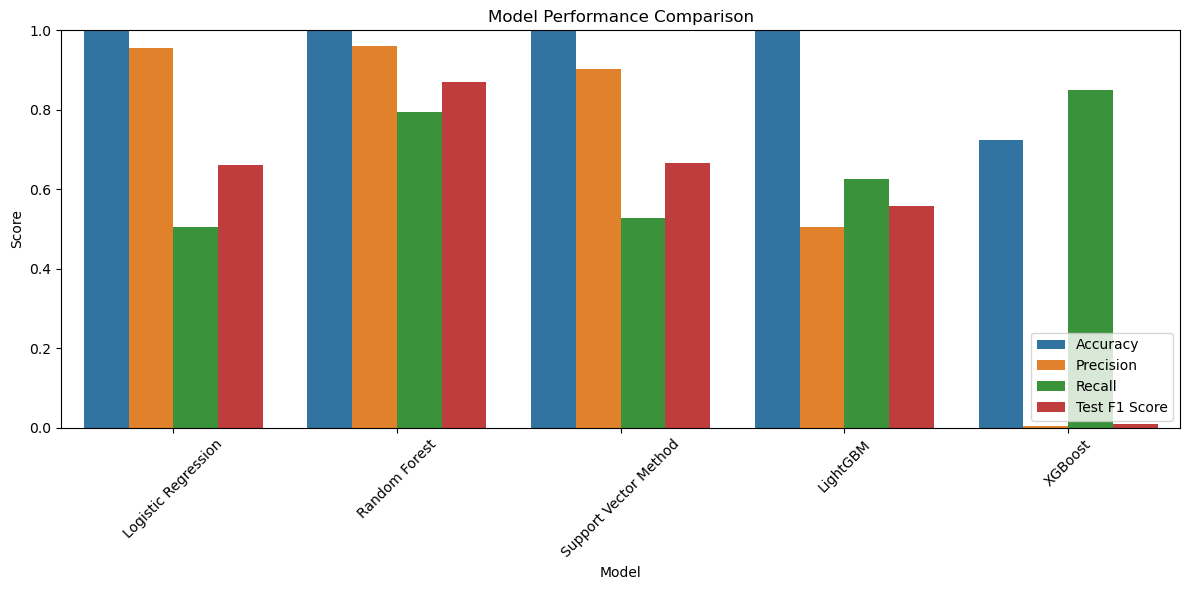

In [14]:
# Melt the DataFrame for better plotting
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'Test F1 Score']
results_melted = results_df.melt(id_vars='Model', value_vars=metrics_to_plot,
                                 var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

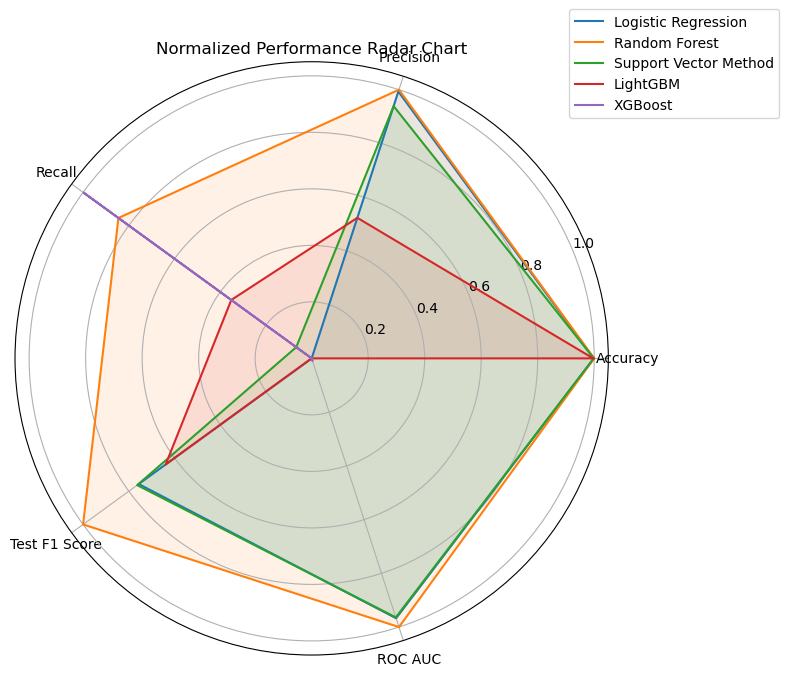

In [15]:
from math import pi

# Normalize all performance metrics to [0,1] scale
radar_data = results_df.copy()
radar_data.set_index('Model', inplace=True)
metrics = ['Accuracy', 'Precision', 'Recall', 'Test F1 Score', 'ROC AUC']
radar_normalized = (radar_data[metrics] - radar_data[metrics].min()) / (radar_data[metrics].max() - radar_data[metrics].min())

# Radar chart setup
labels = radar_normalized.columns.tolist()
num_vars = len(labels)

plt.figure(figsize=(8, 8))
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # Complete the loop

for model in radar_normalized.index:
    values = radar_normalized.loc[model].tolist()
    values += values[:1]  # Close the loop
    plt.polar(angles, values, label=model)
    plt.fill(angles, values, alpha=0.1)

plt.xticks(angles[:-1], labels)
plt.title('Normalized Performance Radar Chart')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

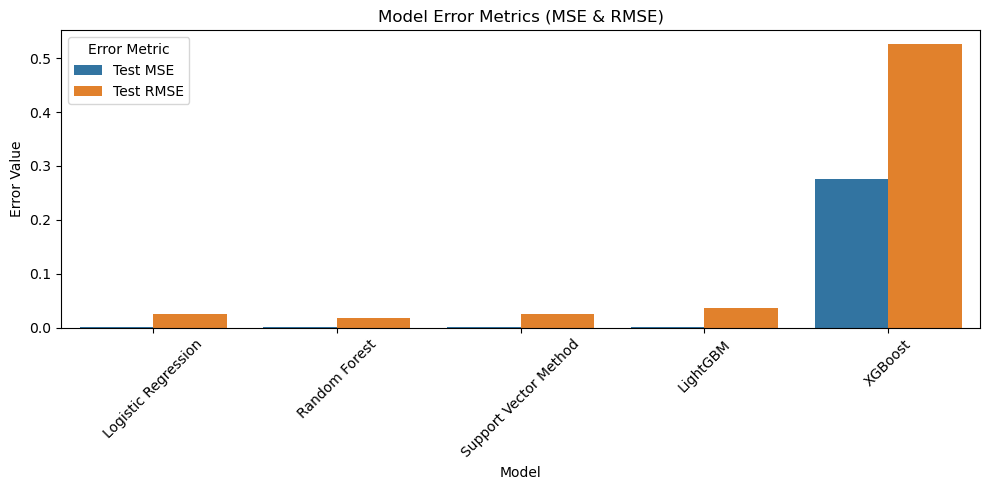

In [16]:
mse_rmse = results_df[['Model', 'Test MSE', 'Test RMSE']].melt(id_vars='Model', var_name='Error Metric', value_name='Error Value')

plt.figure(figsize=(10, 5))
sns.barplot(data=mse_rmse, x='Model', y='Error Value', hue='Error Metric')
plt.title('Model Error Metrics (MSE & RMSE)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

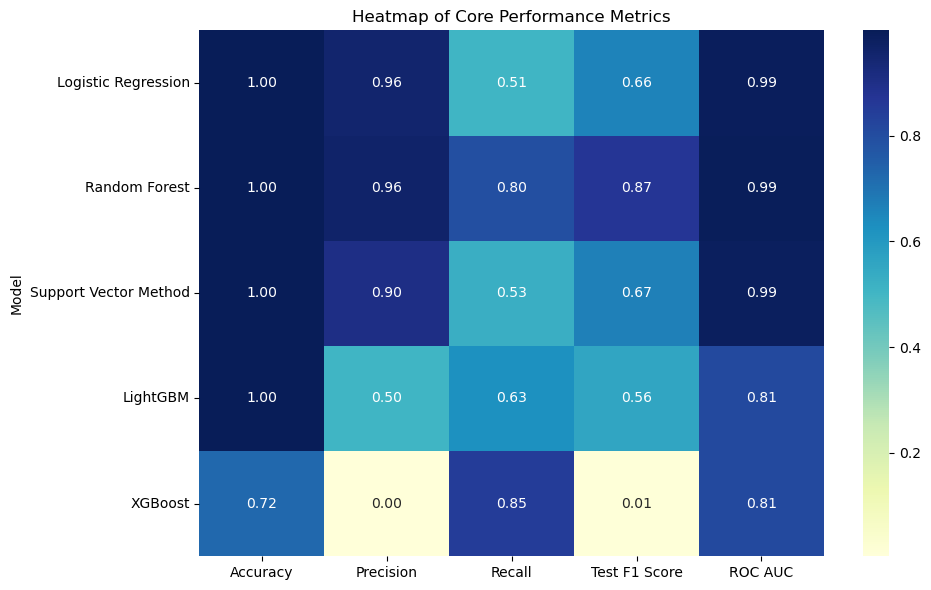

In [17]:
plt.figure(figsize=(10, 6))
sns.heatmap(results_df.set_index('Model')[metrics], annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Heatmap of Core Performance Metrics')
plt.tight_layout()
plt.show()

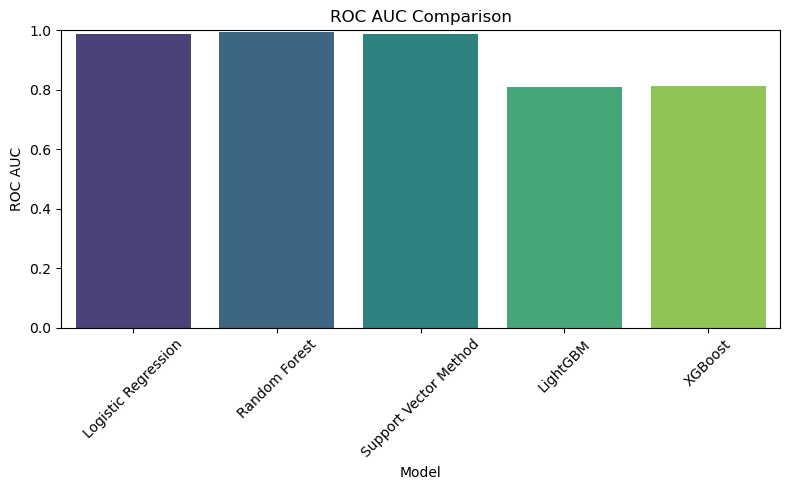

In [18]:
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='Model', y='ROC AUC', palette='viridis')
plt.title('ROC AUC Comparison')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

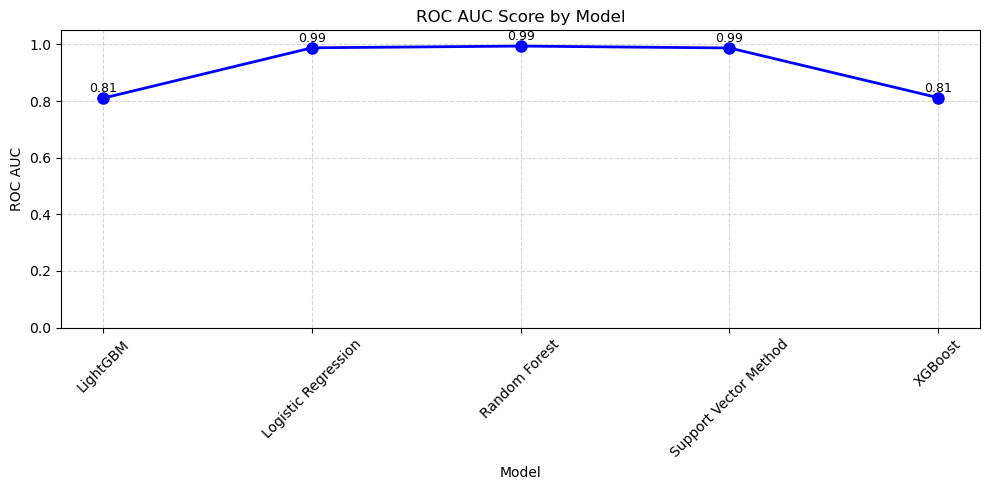

In [19]:
# Sort by model name (alphabetical) or by ROC AUC
roc_sorted = results_df.sort_values(by='Model')  # or use 'ROC AUC' to sort by performance

plt.figure(figsize=(10, 5))
plt.plot(roc_sorted['Model'], roc_sorted['ROC AUC'], marker='o', linestyle='-',
         color='blue', linewidth=2, markersize=8)

# Add value labels on each point
for i, auc in enumerate(roc_sorted['ROC AUC']):
    plt.text(i, auc + 0.01, f"{auc:.2f}", ha='center', va='bottom', fontsize=9)

plt.title('ROC AUC Score by Model')
plt.xlabel('Model')
plt.ylabel('ROC AUC')
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from skopt.space import Real, Integer, Categorical

# Resample data
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

# Apply undersampling + SMOTE
resampling_pipeline = ImbPipeline([
    ('under', RandomUnderSampler(sampling_strategy=0.1, random_state=42)),
    ('smote', SMOTE(sampling_strategy=0.5, k_neighbors=1, random_state=42)),
])

X_resampled, y_resampled = resampling_pipeline.fit_resample(X, y)
combined_weight_resampled = X_resampled['combined_weight']
X_resampled = X_resampled.drop(columns=['combined_weight'])

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X_resampled, y_resampled, combined_weight_resampled,
    test_size=0.2, stratify=y_resampled, random_state=42
)

In [21]:
from sklearn.model_selection import GridSearchCV

# General model grid search function
def grid_search_pipeline(model, param_grid, model_name):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', GridSearchCV(model, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=0))
    ])
    pipeline.fit(X_train, y_train)
    results = evaluate_model(pipeline, model_name)
    return results

In [22]:
grid_param_grids = {
    "Random Forest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "LightGBM": {
        "num_leaves": [31, 50],
        "learning_rate": [0.01, 0.1],
        "n_estimators": [100, 200],
        "feature_name": ['auto']
    },
    "Gradient Boosting": {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7, 9]
    },
    "HistGradientBoosting": {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_iter': [100, 200, 300],
        'max_depth': [3, 5, 7, 9]
    },
    "XGBoost": {
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, 9],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    },
    "SGDClassifier": {
        'alpha': [0.0001, 0.001],
        'penalty': ["l2", "l1"],
        'learning_rate': ["optimal", "invscaling"],
        'eta0': [0.01, 0.1]
    }
}

In [23]:
# --- Random Forest ---
rf_result = grid_search_pipeline(
    RandomForestClassifier(random_state=42),
    grid_param_grids["Random Forest"],
    "Random Forest"
)

--- Random Forest ---
[LightGBM] [Info] Number of positive: 4372, number of negative: 3389017
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 3393389, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001288 -> initscore=-6.653075
[LightGBM] [Info] Start training from score -6.653075
[LightGBM] [Info] Number of positive: 4372, number of negative: 3389017
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 3393389, number of used fea

In [24]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings(
        "ignore",
        category=UserWarning
    )

    # --- LightGBM ---
    lgb_result = grid_search_pipeline(
        LGBMClassifier(random_state=42, verbose=-1),
        grid_param_grids["LightGBM"],
        "LightGBM"
    )

/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/lightgbm/basic.py:2137: UserWarning: feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.
  _log_warning(
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/lightgbm/basic.py:2137: UserWarning: feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.
  _log_warning(
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/lightgbm/basic.py:2137: UserWarning: feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.
  _log_warning(
/opt/anacond

--- LightGBM ---


/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/lightgbm/basic.py:2137: UserWarning: feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.
  _log_warning(
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/lightgbm/basic.py:2137: UserWarning: feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.
  _log_warning(
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/lightgbm/basic.py:2137: UserWarning: feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.
  _log_warning(
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/lightgbm/basic.py:2137: UserWarning: feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset construc

Model               LightGBM
Accuracy             0.99695
Precision           0.993799
Recall              0.997072
Train F1 Score       0.99971
Test F1 Score       0.995433
ROC AUC             0.999901
Train MSE           0.000193
Test MSE             0.00305
Train RMSE          0.013898
Test RMSE           0.055226
Train Score         0.999954
Validation Score     0.99338
dtype: object



/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [25]:
# --- Gradient Boosting ---
gb_result = grid_search_pipeline(
    GradientBoostingClassifier(random_state=42),
    grid_param_grids["Gradient Boosting"],
    "Gradient Boosting"
)

--- Gradient Boosting ---
Model               Gradient Boosting
Accuracy                     0.997072
Precision                    0.994763
Recall                       0.996462
Train F1 Score                    1.0
Test F1 Score                0.995612
ROC AUC                      0.999857
Train MSE                         0.0
Test MSE                     0.002928
Train RMSE                        0.0
Test RMSE                     0.05411
Train Score                       1.0
Validation Score             0.993237
dtype: object



In [26]:
# --- HistGradientBoosting ---
hgb_result = grid_search_pipeline(
    HistGradientBoostingClassifier(random_state=42),
    grid_param_grids["HistGradientBoosting"],
    "HistGradientBoosting"
)

--- HistGradientBoosting ---
Model               HistGradientBoosting
Accuracy                        0.994388
Precision                       0.988128
Recall                           0.99512
Train F1 Score                  0.993128
Test F1 Score                   0.991612
ROC AUC                         0.999747
Train MSE                       0.004595
Test MSE                        0.005612
Train RMSE                      0.067788
Test RMSE                       0.074912
Train Score                     0.998011
Validation Score                0.991954
dtype: object



In [27]:
# --- XGBoost ---
xgb_result = grid_search_pipeline(
    XGBClassifier(random_state=42, eval_metric='logloss'),
    grid_param_grids["XGBoost"],
    "XGBoost"
)

--- XGBoost ---
Model                XGBoost
Accuracy            0.996625
Precision           0.993192
Recall              0.996706
Train F1 Score      0.999283
Test F1 Score       0.994946
ROC AUC             0.999897
Train MSE           0.000478
Test MSE            0.003375
Train RMSE          0.021859
Test RMSE           0.058097
Train Score         0.999398
Validation Score     0.99286
dtype: object



In [28]:
# --- SGDClassifier ---
sgd_result = grid_search_pipeline(
    SGDClassifier(loss='log_loss', random_state=42, max_iter=1000, tol=1e-3),
    grid_param_grids["SGDClassifier"],
    "SGDClassifier"
)

/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: d

--- SGDClassifier ---


/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: d

Model               SGDClassifier
Accuracy                 0.964215
Precision                0.953402
Recall                   0.938514
Train F1 Score           0.941687
Test F1 Score            0.945899
ROC AUC                  0.993333
Train MSE                0.038551
Test MSE                 0.035785
Train RMSE               0.196343
Test RMSE                 0.18917
Train Score              0.942995
Validation Score         0.942599
dtype: object



/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: d

In [29]:
# Compile and display results
grid_results_df = pd.DataFrame([
    rf_result, lgb_result, gb_result,
    hgb_result, xgb_result, sgd_result
])

In [30]:
# Format results into a DataFrame
columns = [
    'Model',
    'Accuracy', 'Precision', 'Recall', 'Train F1 Score', 'Test F1 Score', 'ROC AUC', 'Train MSE', 'Train RMSE', 
    'Test MSE',  'Test RMSE', 'Train Score', 'Validation Score'
]
grid_results = pd.DataFrame(grid_results_df, columns=columns)
print("\nTraining vs Test Performance Comparison:")
print(grid_results)


Training vs Test Performance Comparison:
                  Model  Accuracy  Precision    Recall  Train F1 Score  \
0         Random Forest  0.996706   0.993914  0.996218        0.999725   
1              LightGBM  0.996950   0.993799  0.997072        0.999710   
2     Gradient Boosting  0.997072   0.994763  0.996462        1.000000   
3  HistGradientBoosting  0.994388   0.988128  0.995120        0.993128   
4               XGBoost  0.996625   0.993192  0.996706        0.999283   
5         SGDClassifier  0.964215   0.953402  0.938514        0.941687   

   Test F1 Score   ROC AUC  Train MSE  Train RMSE  Test MSE  Test RMSE  \
0       0.995065  0.999920   0.000183    0.013528  0.003294   0.057392   
1       0.995433  0.999901   0.000193    0.013898  0.003050   0.055226   
2       0.995612  0.999857   0.000000    0.000000  0.002928   0.054110   
3       0.991612  0.999747   0.004595    0.067788  0.005612   0.074912   
4       0.994946  0.999897   0.000478    0.021859  0.003375   0.05809

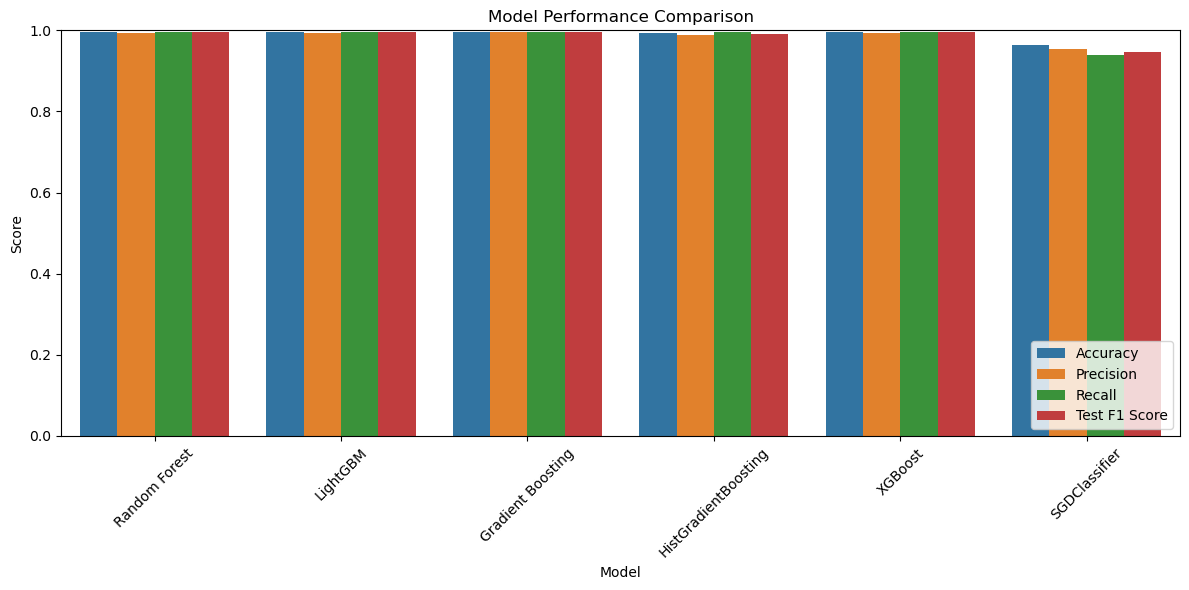

In [31]:
# Melt the DataFrame for better plotting
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'Test F1 Score']
grid_results_melted = grid_results_df.melt(id_vars='Model', value_vars=metrics_to_plot,
                                 var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=grid_results_melted, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

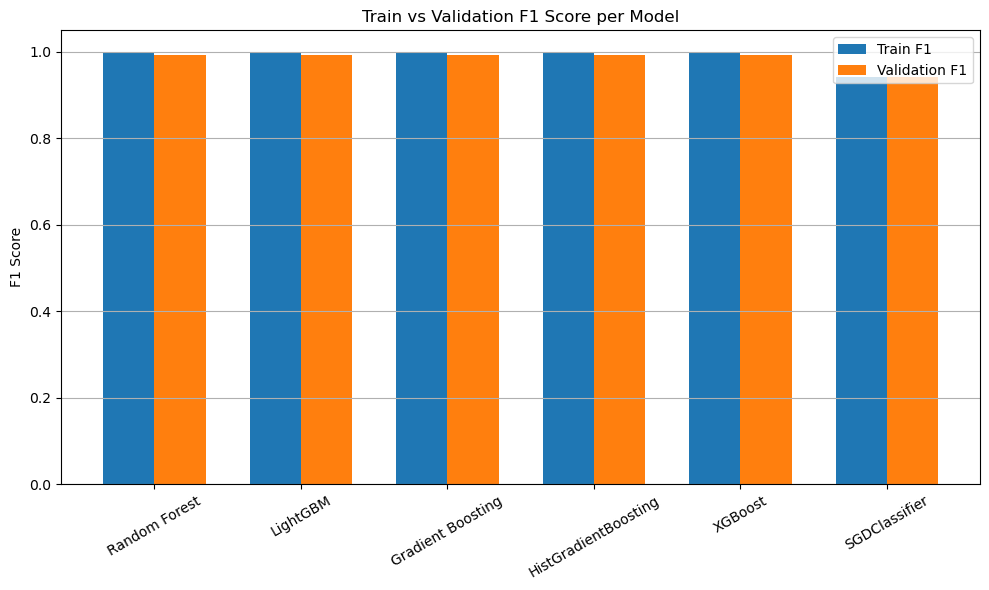

In [32]:
# Plotting
plt.figure(figsize=(10, 6))
x = np.arange(len(grid_results))
bar_width = 0.35

plt.bar(x - bar_width/2, grid_results['Train Score'], width=bar_width, label='Train F1')
plt.bar(x + bar_width/2, grid_results['Validation Score'], width=bar_width, label='Validation F1')

plt.xticks(x, grid_results['Model'], rotation=30)
plt.ylabel("F1 Score")
plt.title("Train vs Validation F1 Score per Model")
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.show()

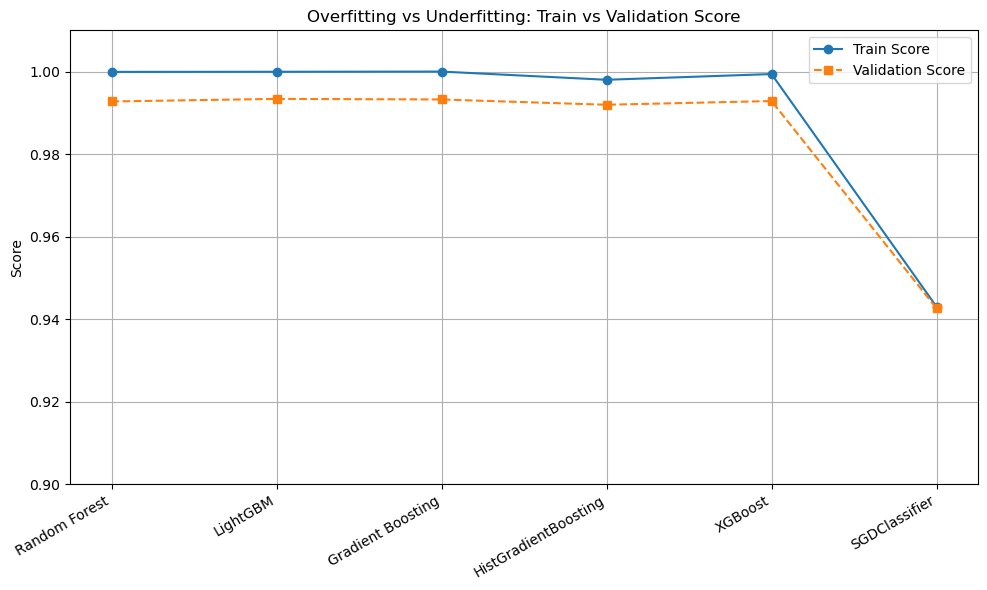

In [33]:
# Plotting the Train Score vs. Validation Score
plt.figure(figsize=(10, 6))
plt.plot(grid_results["Model"], grid_results["Train Score"], marker='o', label="Train Score", linestyle='-')
plt.plot(grid_results["Model"], grid_results["Validation Score"], marker='s', label="Validation Score", linestyle='--')
plt.xticks(rotation=30, ha='right')
plt.ylim(0.9, 1.01)
plt.ylabel("Score")
plt.title("Overfitting vs Underfitting: Train vs Validation Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
from skopt import BayesSearchCV

# General model bayes search function
def bayes_search_pipeline(base_model, search_space, name):
    search = BayesSearchCV(
        estimator=base_model,
        search_spaces=search_space,
        scoring='f1',
        n_iter=20,
        cv=3,
        n_jobs=-1,
        verbose=0,
        random_state=42
    )

    if hasattr(base_model, 'predict_proba'):
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', search)
        ])
    else:
        # Skip scaler if not needed
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', search)
        ])
    
    pipeline.fit(X_train, y_train)
    result = evaluate_model(pipeline, name)
    result['Model'] = name
    return result

In [35]:
bayes_param_grids = {
    "Random Forest": {
        'n_estimators': Integer(100, 300),
        'max_depth': Integer(5, 20),
        'min_samples_split': Integer(2, 10),
        'min_samples_leaf': Integer(1, 4)
    },
    "LightGBM": {
        'num_leaves': Integer(20, 50),
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'n_estimators': Integer(100, 200)
    },
    "Gradient Boosting": {
        'n_estimators': Integer(100, 300),
        'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
        'max_depth': Integer(3, 10)
    },
    "HistGradientBoosting": {
        'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
        'max_iter': Integer(100, 300),
        'max_depth': Integer(3, 10)
    },
    "XGBoost": {
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'n_estimators': Integer(100, 300),
        'max_depth': Integer(3, 10),
        'subsample': Real(0.5, 1.0),
        'colsample_bytree': Real(0.5, 1.0)
    },
    "SGDClassifier": {
        'classifier__alpha': Real(1e-5, 1e-1, prior='log-uniform'),
        'classifier__penalty': Categorical(['l1', 'l2']),
        'classifier__learning_rate': Categorical(['invscaling', 'optimal']),
        'classifier__eta0': Real(0.001, 0.1)
    }
}

In [36]:
# --- Random Forest ---
rf_result = bayes_search_pipeline(
    RandomForestClassifier(random_state=42),
    bayes_param_grids["Random Forest"],
    "Random Forest"
)

--- Random Forest ---
Model               Random Forest
Accuracy                 0.996706
Precision                0.993914
Recall                   0.996218
Train F1 Score           0.999725
Test F1 Score            0.995065
ROC AUC                   0.99992
Train MSE                0.000183
Test MSE                 0.003294
Train RMSE               0.013528
Test RMSE                0.057392
Train Score              0.999878
Validation Score         0.992707
dtype: object



In [37]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)

    # --- LightGBM ---
    lgb_result = bayes_search_pipeline(
        LGBMClassifier(random_state=42, verbose=-1),
        bayes_param_grids["LightGBM"],
        "LightGBM"
    )

/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with featur

--- LightGBM ---


/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with featur

Model               LightGBM
Accuracy            0.997316
Precision           0.994767
Recall              0.997194
Train F1 Score           1.0
Test F1 Score       0.995979
ROC AUC             0.999923
Train MSE                0.0
Test MSE            0.002684
Train RMSE               0.0
Test RMSE           0.051806
Train Score          0.99955
Validation Score    0.993502
dtype: object



/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [38]:
# --- Gradient Boosting ---
gb_result = bayes_search_pipeline(
    GradientBoostingClassifier(random_state=42),
    bayes_param_grids["Gradient Boosting"],
    "Gradient Boosting"
)

--- Gradient Boosting ---
Model               Gradient Boosting
Accuracy                     0.997397
Precision                    0.995612
Recall                       0.996584
Train F1 Score                    1.0
Test F1 Score                0.996098
ROC AUC                      0.999891
Train MSE                         0.0
Test MSE                     0.002603
Train RMSE                        0.0
Test RMSE                    0.051015
Train Score                       1.0
Validation Score             0.993645
dtype: object



In [39]:
# --- HistGradientBoosting ---
hgb_result = bayes_search_pipeline(
    HistGradientBoostingClassifier(random_state=42),
    bayes_param_grids["HistGradientBoosting"],
    "HistGradientBoosting"
)

--- HistGradientBoosting ---
Model               HistGradientBoosting
Accuracy                         0.99634
Precision                       0.992707
Recall                           0.99634
Train F1 Score                  0.998506
Test F1 Score                    0.99452
ROC AUC                         0.999815
Train MSE                       0.000996
Test MSE                         0.00366
Train RMSE                      0.031564
Test RMSE                       0.060497
Train Score                     0.998202
Validation Score                0.992273
dtype: object



In [40]:
# --- XGBoost ---
xgb_result = bayes_search_pipeline(
    XGBClassifier(random_state=42, eval_metric='logloss'),
    bayes_param_grids["XGBoost"],
    "XGBoost"
)

--- XGBoost ---
Model                XGBoost
Accuracy            0.996665
Precision           0.993313
Recall              0.996706
Train F1 Score       0.99971
Test F1 Score       0.995007
ROC AUC             0.999904
Train MSE           0.000193
Test MSE            0.003335
Train RMSE          0.013898
Test RMSE           0.057746
Train Score         0.999916
Validation Score    0.992797
dtype: object



In [41]:
sgd_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SGDClassifier(loss='log_loss', random_state=42, max_iter=1000, tol=1e-3))
])

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    # --- SGDClassifier ---
    sgd_result = bayes_search_pipeline(
        sgd_pipeline,
        bayes_param_grids["SGDClassifier"],
        "SGDClassifier"
    )

/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: d

--- SGDClassifier ---


/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: d

Model               SGDClassifier
Accuracy                 0.966207
Precision                0.956721
Recall                   0.941198
Train F1 Score           0.945611
Test F1 Score            0.948896
ROC AUC                   0.99345
Train MSE                0.035958
Test MSE                 0.033793
Train RMSE               0.189627
Test RMSE                0.183828
Train Score              0.942748
Validation Score         0.942456
dtype: object



/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [42]:
# Compile results
bayes_results_df = pd.DataFrame([
    rf_result,
    lgb_result,
    gb_result,
    hgb_result,
    xgb_result,
    sgd_result
])

print(bayes_results_df.sort_values(by="Test F1 Score", ascending=False))

                  Model  Accuracy  Precision    Recall  Train F1 Score  \
2     Gradient Boosting  0.997397   0.995612  0.996584        1.000000   
1              LightGBM  0.997316   0.994767  0.997194        1.000000   
0         Random Forest  0.996706   0.993914  0.996218        0.999725   
4               XGBoost  0.996665   0.993313  0.996706        0.999710   
3  HistGradientBoosting  0.996340   0.992707  0.996340        0.998506   
5         SGDClassifier  0.966207   0.956721  0.941198        0.945611   

   Test F1 Score   ROC AUC  Train MSE  Test MSE  Train RMSE  Test RMSE  \
2       0.996098  0.999891   0.000000  0.002603    0.000000   0.051015   
1       0.995979  0.999923   0.000000  0.002684    0.000000   0.051806   
0       0.995065  0.999920   0.000183  0.003294    0.013528   0.057392   
4       0.995007  0.999904   0.000193  0.003335    0.013898   0.057746   
3       0.994520  0.999815   0.000996  0.003660    0.031564   0.060497   
5       0.948896  0.993450   0.035958

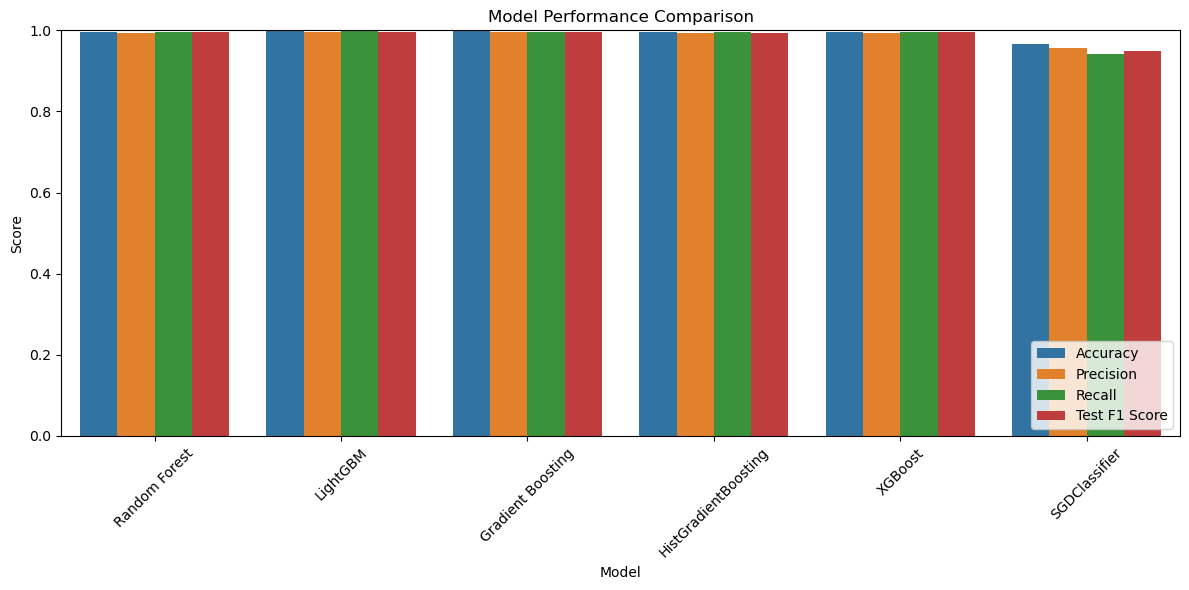

In [43]:
# Melt the DataFrame for better plotting
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'Test F1 Score']
bayes_results_melted = bayes_results_df.melt(id_vars='Model', value_vars=metrics_to_plot,
                                 var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=bayes_results_melted, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [44]:
# Format results into a DataFrame
columns = [
    'Model',
    'Accuracy', 'Precision', 'Recall', 'Train F1 Score', 'Test F1 Score', 'ROC AUC', 'Train MSE', 'Train RMSE', 
    'Test MSE',  'Test RMSE', 'Train Score', 'Validation Score'
]
bayes_results = pd.DataFrame(bayes_results_df, columns=columns)
print("\nTraining vs Test Performance Comparison:")
print(bayes_results)


Training vs Test Performance Comparison:
                  Model  Accuracy  Precision    Recall  Train F1 Score  \
0         Random Forest  0.996706   0.993914  0.996218        0.999725   
1              LightGBM  0.997316   0.994767  0.997194        1.000000   
2     Gradient Boosting  0.997397   0.995612  0.996584        1.000000   
3  HistGradientBoosting  0.996340   0.992707  0.996340        0.998506   
4               XGBoost  0.996665   0.993313  0.996706        0.999710   
5         SGDClassifier  0.966207   0.956721  0.941198        0.945611   

   Test F1 Score   ROC AUC  Train MSE  Train RMSE  Test MSE  Test RMSE  \
0       0.995065  0.999920   0.000183    0.013528  0.003294   0.057392   
1       0.995979  0.999923   0.000000    0.000000  0.002684   0.051806   
2       0.996098  0.999891   0.000000    0.000000  0.002603   0.051015   
3       0.994520  0.999815   0.000996    0.031564  0.003660   0.060497   
4       0.995007  0.999904   0.000193    0.013898  0.003335   0.05774

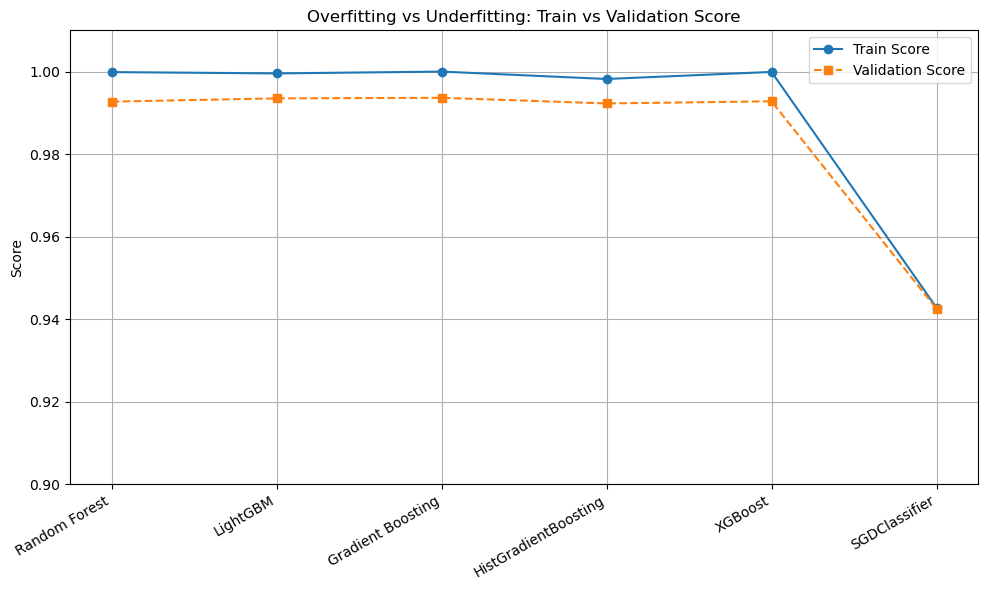

In [45]:
# Plotting the Train Score vs. Validation Score
plt.figure(figsize=(10, 6))
plt.plot(bayes_results["Model"], bayes_results["Train Score"], marker='o', label="Train Score", linestyle='-')
plt.plot(bayes_results["Model"], bayes_results["Validation Score"], marker='s', label="Validation Score", linestyle='--')
plt.xticks(rotation=30, ha='right')
plt.ylim(0.9, 1.01)
plt.ylabel("Score")
plt.title("Overfitting vs Underfitting: Train vs Validation Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

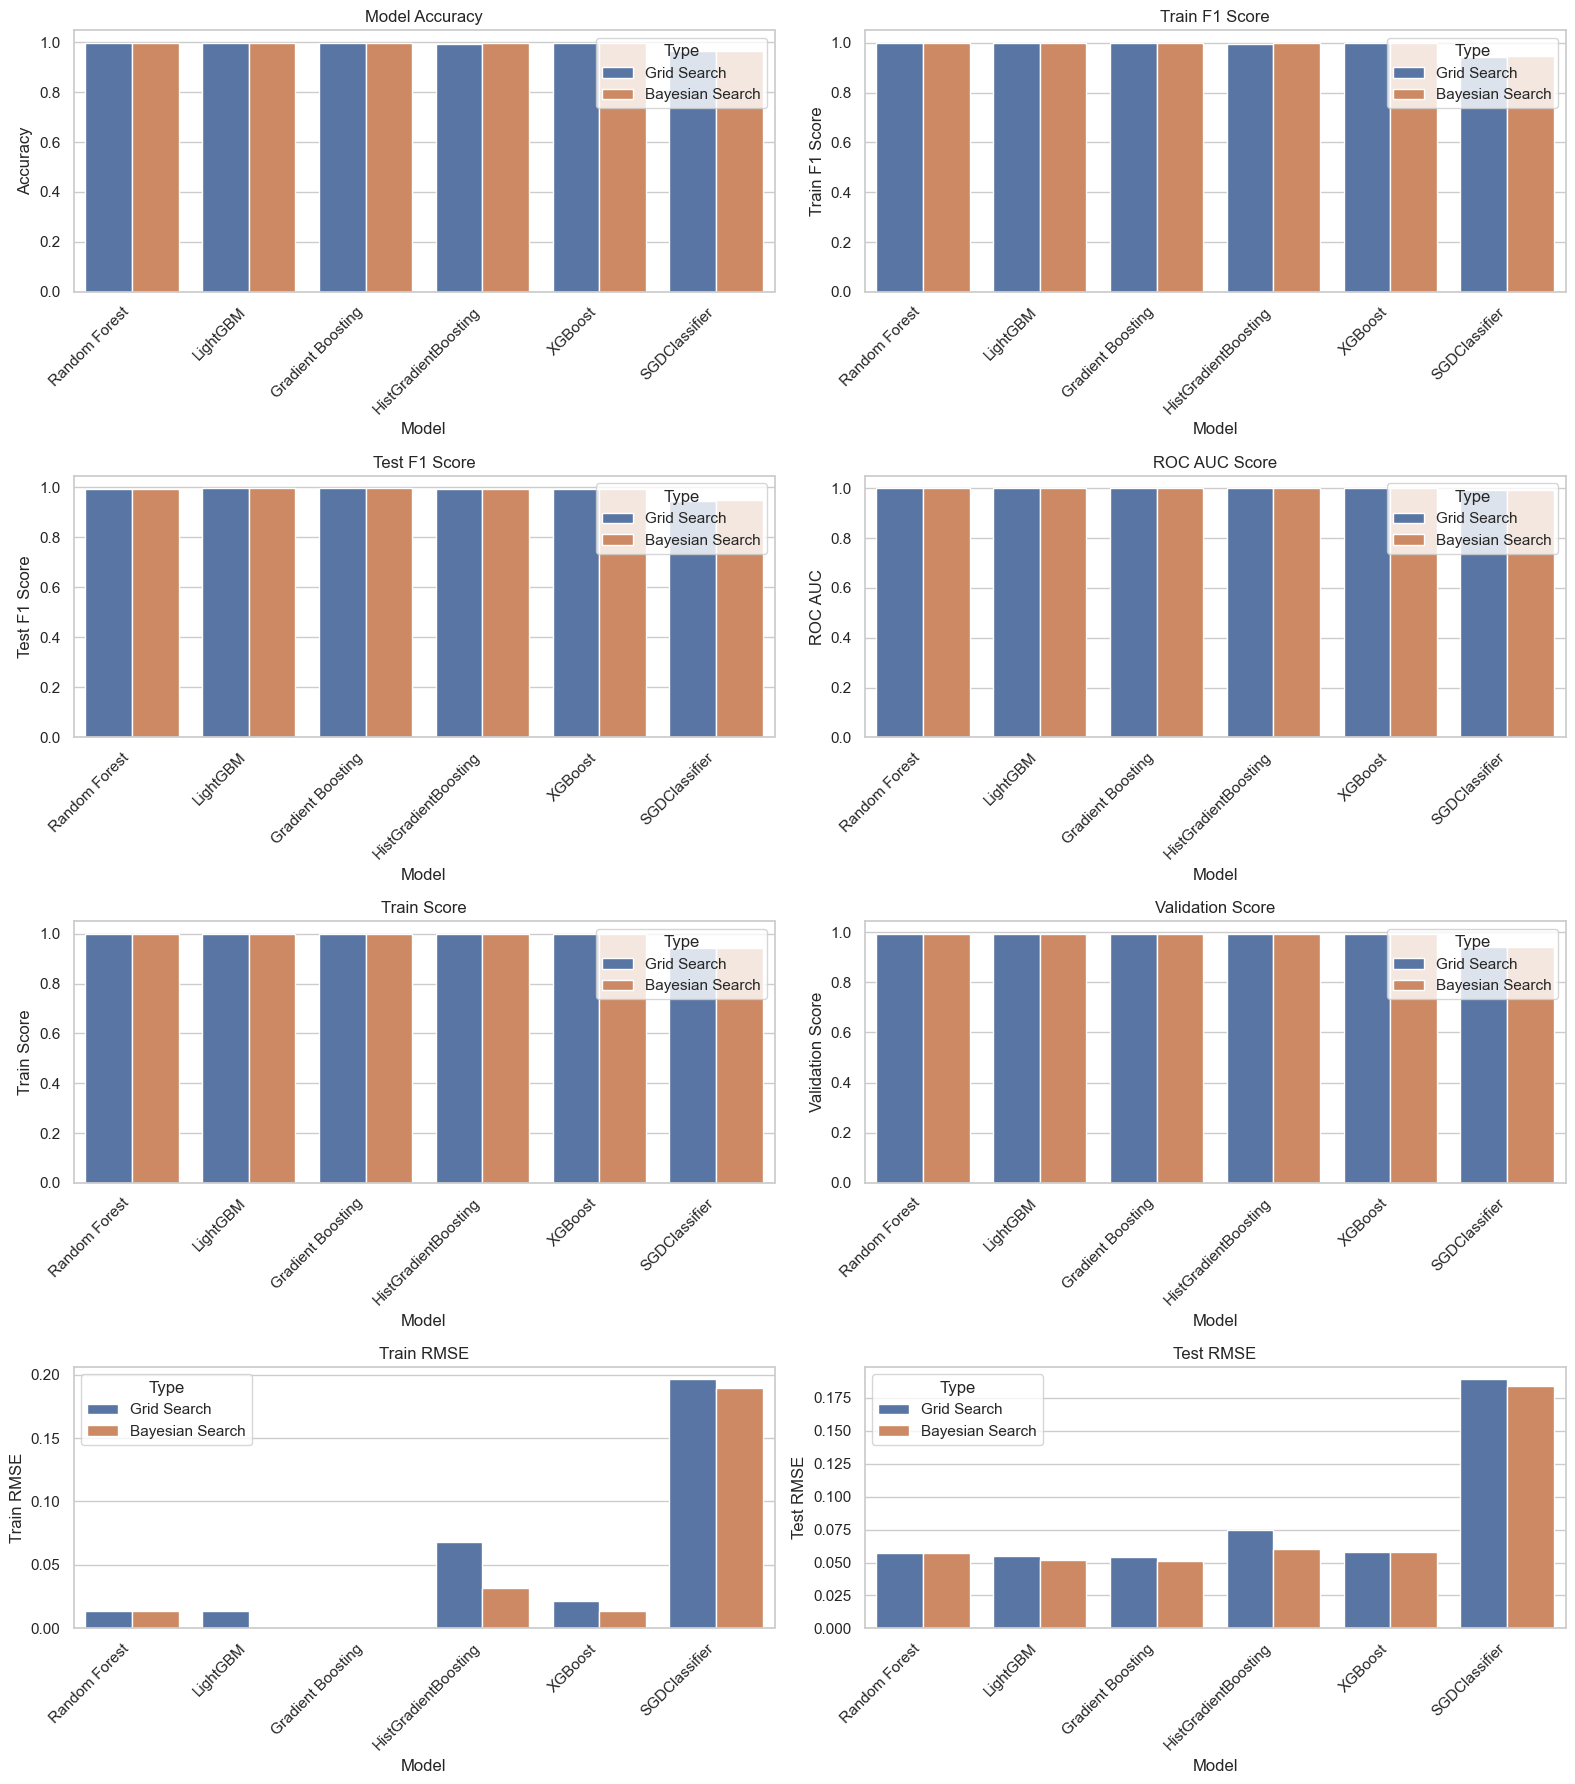

In [46]:
# Set up
sns.set(style="whitegrid")
models = ["Random Forest", "LightGBM", "Gradient Boosting", "HistGradientBoosting", "XGBoost", "SGDClassifier"]
metrics = [
    ("Accuracy", "Model Accuracy"),
    ("Train F1 Score", "Train F1 Score"),
    ("Test F1 Score", "Test F1 Score"),
    ("ROC AUC", "ROC AUC Score"),
    ("Train Score", "Train Score"),
    ("Validation Score", "Validation Score"),
    ("Train RMSE", "Train RMSE"),
    ("Test RMSE", "Test RMSE"),
]

# Combine results
grid_results["Type"] = "Grid Search"
bayes_results["Type"] = "Bayesian Search"
all_results = pd.concat([grid_results, bayes_results], ignore_index=True)

# Only use selected models
all_results = all_results[all_results['Model'].isin(models)]

# Plotting
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16, 18))
axs = axs.flatten()

for i, (metric, title) in enumerate(metrics):
    sns.barplot(data=all_results, x="Model", y=metric, hue="Type", ax=axs[i])
    axs[i].set_title(title)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

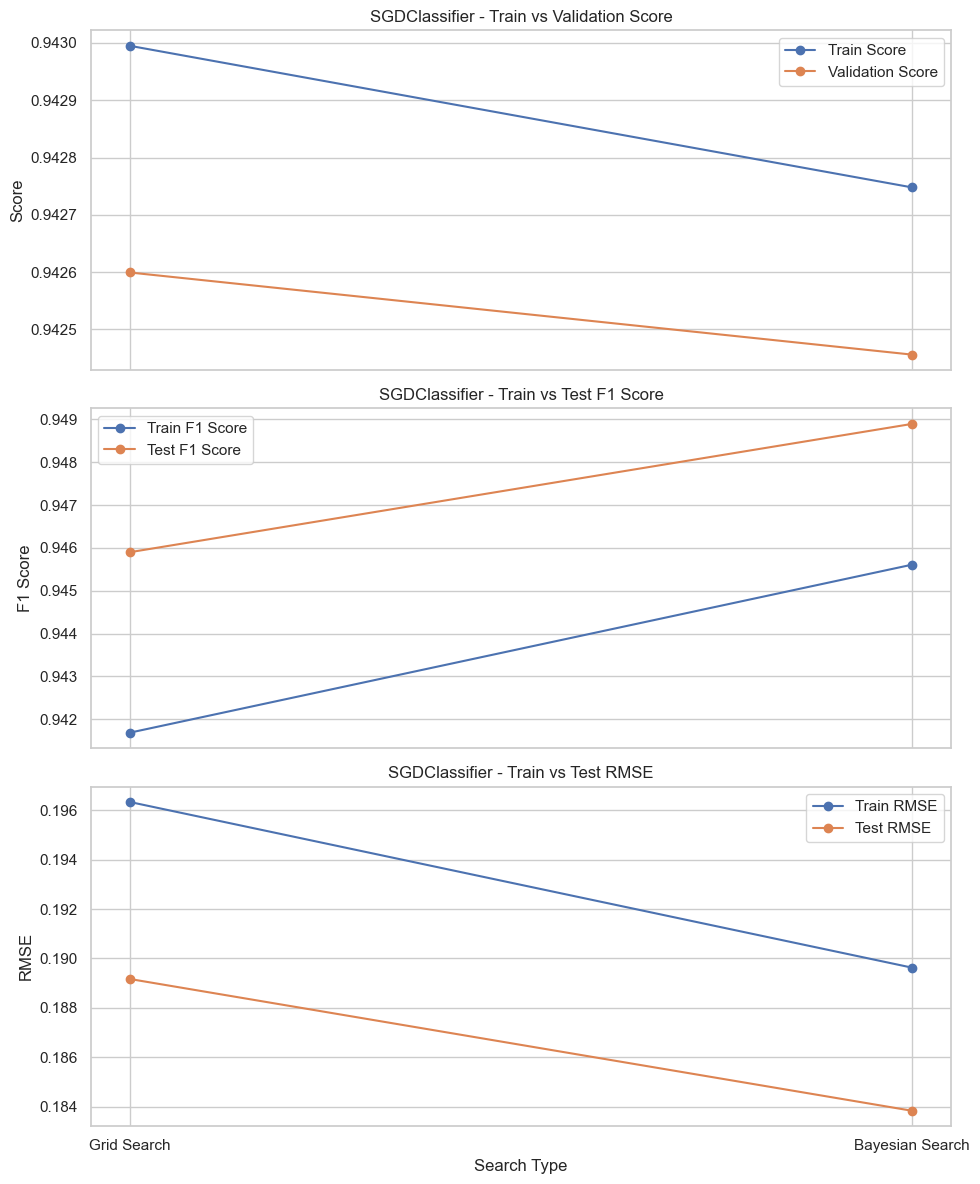

In [47]:
# Filter SGDClassifier results
sgd_grid = grid_results[grid_results['Model'] == 'SGDClassifier'].copy()
sgd_bayes = bayes_results[bayes_results['Model'] == 'SGDClassifier'].copy()

# Add search type for clarity
sgd_grid["Search Type"] = "Grid Search"
sgd_bayes["Search Type"] = "Bayesian Search"

# Combine
sgd_results = pd.concat([sgd_grid, sgd_bayes], ignore_index=True)

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Train vs Validation Score
axes[0].plot(sgd_results["Search Type"], sgd_results["Train Score"], marker='o', label='Train Score')
axes[0].plot(sgd_results["Search Type"], sgd_results["Validation Score"], marker='o', label='Validation Score')
axes[0].set_ylabel("Score")
axes[0].set_title("SGDClassifier - Train vs Validation Score")
axes[0].legend()
axes[0].grid(True)

# F1 Score
axes[1].plot(sgd_results["Search Type"], sgd_results["Train F1 Score"], marker='o', label='Train F1 Score')
axes[1].plot(sgd_results["Search Type"], sgd_results["Test F1 Score"], marker='o', label='Test F1 Score')
axes[1].set_ylabel("F1 Score")
axes[1].set_title("SGDClassifier - Train vs Test F1 Score")
axes[1].legend()
axes[1].grid(True)

# RMSE
axes[2].plot(sgd_results["Search Type"], sgd_results["Train RMSE"], marker='o', label='Train RMSE')
axes[2].plot(sgd_results["Search Type"], sgd_results["Test RMSE"], marker='o', label='Test RMSE')
axes[2].set_ylabel("RMSE")
axes[2].set_title("SGDClassifier - Train vs Test RMSE")
axes[2].legend()
axes[2].grid(True)

plt.xlabel("Search Type")
plt.tight_layout()
plt.show()

In [48]:
# Set index to 'Model' for proper row labeling
grid_heatmap_df = grid_results.set_index('Model')
bayes_heatmap_df = bayes_results.set_index('Model')

# Selected metrics only
selected_metrics = [
    'Accuracy', 'Precision', 'Recall',
    'Test F1 Score', 'ROC AUC',
    'Test MSE', 'Test RMSE'
]

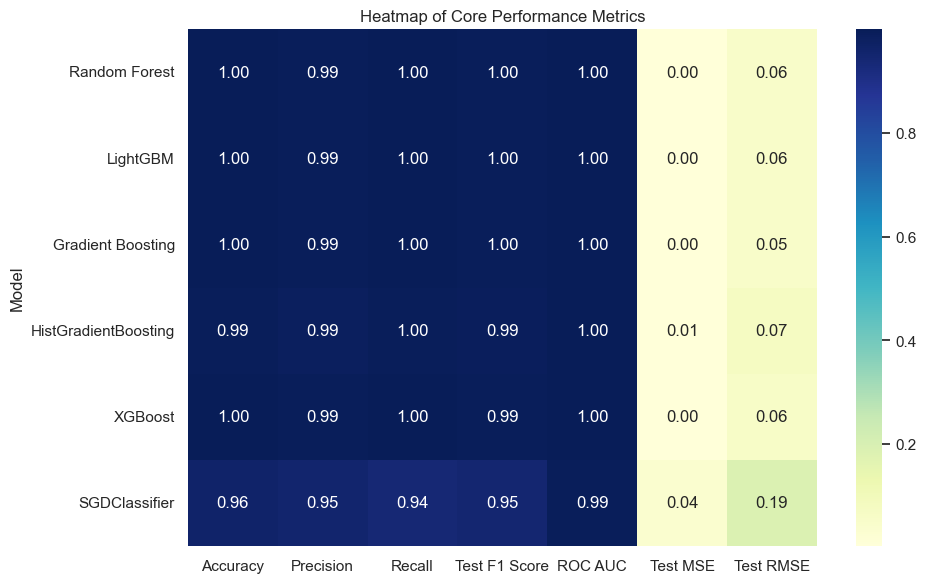

In [49]:
# Grid Search Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(grid_heatmap_df[selected_metrics], annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Heatmap of Core Performance Metrics')
plt.tight_layout()
plt.show()

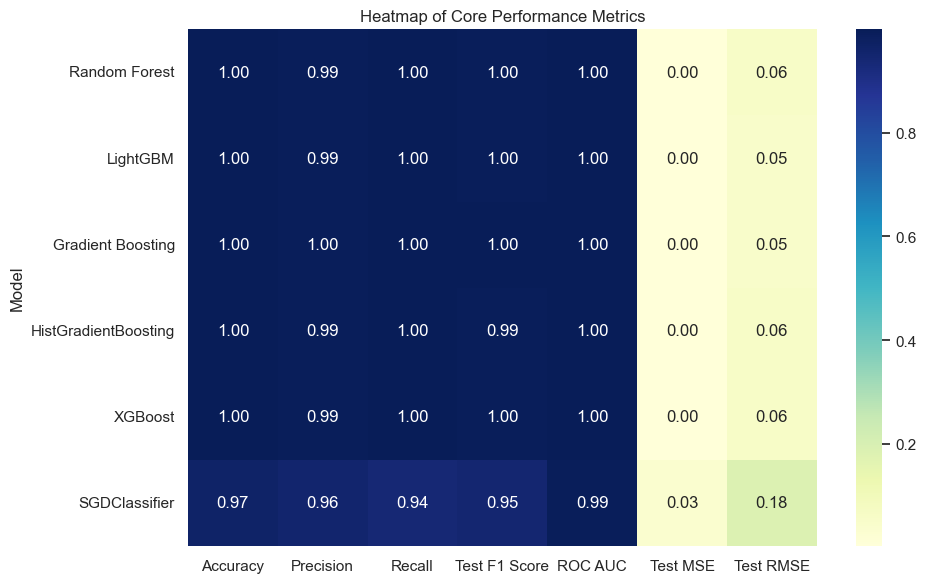

In [50]:
# Bayesian Search Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(bayes_heatmap_df[selected_metrics], annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Heatmap of Core Performance Metrics')
plt.tight_layout()
plt.show()